In [1]:
import numpy as np
import matplotlib.pyplot as plt

(-0.01, 1.01)

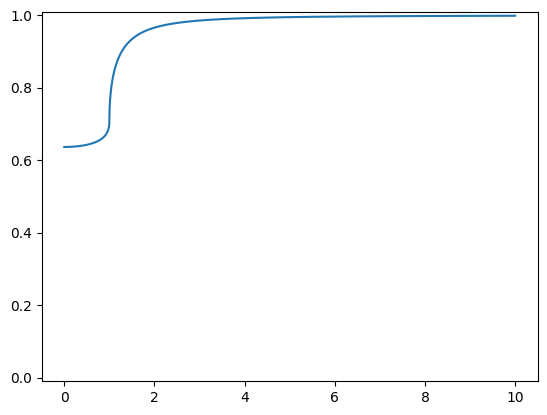

In [28]:
def R(K, w):
    if K >= w:
        return np.cos(0.5 * np.arcsin(w / K))
    else:
        Z = np.pi / np.sqrt(w**2 - K**2)

        x = np.linspace(-np.pi / 2, np.pi / 2, 10000)
        f_x = np.cos(x) / (w - K * np.sin(2 * x))
        return np.sum(f_x * (x[1] - x[0])) / Z


w = 1
K_list = np.linspace(0, 10., 10000)
R_list = np.array([R(K, w) for K in K_list])

plt.plot(K_list, R_list)
plt.ylim((-0.01, 1.01))

/tmp/ipykernel_783957/4148426344.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(K_list, np.where(limited_p > 0, np.log(limited_p), 0.), label=f"$R^*={R_limit}$")


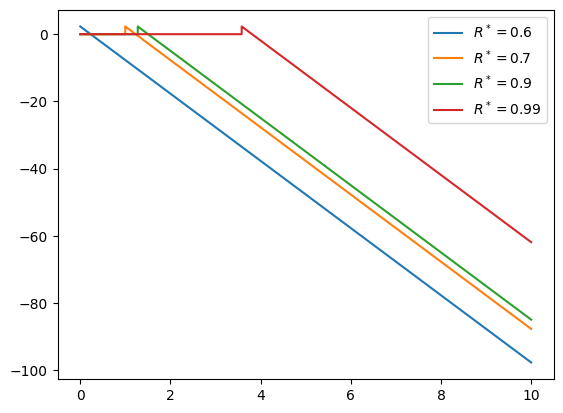

In [36]:
beta = 10.0

for R_limit in [0.6, 0.7, 0.9, 0.99]:
    limited_f = np.where(R_list > R_limit, np.exp(- beta * K_list), 0.)
    limited_p = limited_f / (np.sum(limited_f) * (K_list[1] - K_list[0]))

    plt.plot(K_list, np.where(limited_p > 0, limited_p * np.log(limited_p), 0.), label=f"$R^*={R_limit}$")
plt.legend()